# Data Preparation

Modify the data so ML algorithms can properly learn from it.

The majority of reasons why we apply some of the changes are described in the data understanding notebook. If not, we explain it here.

### Imports

In [42]:
# Import necessary libraries, functions, objects...
import numpy as np
import pandas as pd



### Load dataset

In [43]:
df = pd.read_csv('data/bank/bank_term_deposit.csv')

## Select Data

After the previous exploration you may decide to use or not use some of the data sets.

For this exercise there is **no decision to make, you use the only data set we have**.

## Clean Data

### Remove unnecessary features (if any)

in questo caso non serve eliminare le colonne

#### IMPUTAZIONE dei 28 "unknown" in JOB 

Imputare job "unknown" basandoci su:

Situazione finanziaria (balance, default)
Prestiti (housing, loan)
Guardando un campione del 35% del dataset per decidere

MOLTO IMPORTANTE... QUESTA OPERAZIONE E` STATA FATTA NEL FILE PRECEDETNE MA NON SALAVATA NEL CSV... MAI FARE CAMBIAMAENTI NEL DATA UNDESTANDING 

In [44]:
df['job'] = df['job'].replace('?', 'unknown')


STEP 1: Analizza il campione (35% dei dati)


In [45]:

# 1. Crea campione random del 35%
np.random.seed(42)  # Per riproducibilità
sample_size = int(len(df) * 0.35)
sample_indices = np.random.choice(df.index, size=sample_size, replace=False)
df_sample = df.loc[sample_indices].copy()

print(f"Sample size: {len(df_sample)} righe (35% di {len(df)})")
print(f"Unknown nel sample: {(df_sample['job'] == 'unknown').sum()}")

Sample size: 1072 righe (35% di 3063)
Unknown nel sample: 15


STEP 2: Analizza pattern nel SAMPLE (esclusi unknown)


In [46]:
# Filtra solo job NOTI nel sample
df_sample_known = df_sample[df_sample['job'] != 'unknown'].copy()

print(f"\nRighe con job noto nel sample: {len(df_sample_known)}")

# Analizza distribuzione job per categorie finanziarie
print("\n" + "="*60)
print("DISTRIBUZIONE JOB per SITUAZIONE FINANZIARIA")
print("="*60)

# Per balance (categorie)
df_sample_known['balance_temp'] = pd.cut(df_sample_known['balance'], 
                                          bins=[-np.inf, 0, 1000, 5000, np.inf],
                                          labels=['negativo', 'basso', 'medio', 'alto'])

print("\n1. JOB per BALANCE:")
job_by_balance = pd.crosstab(df_sample_known['balance_temp'], 
                               df_sample_known['job'], 
                               normalize='index') * 100
print(job_by_balance.round(1))

# Per default
print("\n2. JOB per DEFAULT:")
job_by_default = pd.crosstab(df_sample_known['default'], 
                               df_sample_known['job'], 
                               normalize='index') * 100
print(job_by_default.round(1))

# Per housing
print("\n3. JOB per HOUSING LOAN:")
job_by_housing = pd.crosstab(df_sample_known['housing'], 
                               df_sample_known['job'], 
                               normalize='index') * 100
print(job_by_housing.round(1))

# Per loan
print("\n4. JOB per PERSONAL LOAN:")
job_by_loan = pd.crosstab(df_sample_known['loan'], 
                           df_sample_known['job'], 
                           normalize='index') * 100
print(job_by_loan.round(1))


Righe con job noto nel sample: 1057

DISTRIBUZIONE JOB per SITUAZIONE FINANZIARIA

1. JOB per BALANCE:
job           admin.  blue-collar  entrepreneur  housemaid  management  \
balance_temp                                                             
negativo        14.0         21.2           3.6        2.1        16.6   
basso            9.9         22.1           3.9        1.9        21.7   
medio           14.9         20.4           2.5        2.2        22.2   
alto             8.2         20.5           5.5        5.5        27.4   

job           retired  self-employed  services  student  technician  \
balance_temp                                                          
negativo          2.6            4.7      15.0      1.6        17.6   
basso             3.5            4.7       9.9      1.4        17.8   
medio             5.1            3.6       8.0      1.1        17.1   
alto              8.2            4.1       6.8      1.4        12.3   

job           unemployed

STEP 3: Trova il JOB più probabile per ogni profilo


In [47]:
# Crea profili combinati
print("\n" + "="*60)
print("PROFILI COMBINATI")
print("="*60)

# Profilo: balance + housing + loan
def create_profile(row):
    if row['balance'] < 0:
        bal = 'negativo'
    elif row['balance'] < 1000:
        bal = 'basso'
    elif row['balance'] < 5000:
        bal = 'medio'
    else:
        bal = 'alto'
    
    return f"bal_{bal}_house_{row['housing']}_loan_{row['loan']}"

df_sample_known['profile'] = df_sample_known.apply(create_profile, axis=1)

# Trova job più frequente per ogni profilo
profile_job_map = {}
for profile in df_sample_known['profile'].unique():
    profile_data = df_sample_known[df_sample_known['profile'] == profile]
    most_common_job = profile_data['job'].mode()[0]
    count = len(profile_data)
    profile_job_map[profile] = (most_common_job, count)

print("\nJob più frequente per profilo (top 10):")
sorted_profiles = sorted(profile_job_map.items(), key=lambda x: x[1][1], reverse=True)
for profile, (job, count) in sorted_profiles[:10]:
    print(f"{profile}: {job} (n={count})")


PROFILI COMBINATI

Job più frequente per profilo (top 10):
bal_basso_house_yes_loan_no: blue-collar (n=293)
bal_basso_house_no_loan_no: management (n=224)
bal_medio_house_yes_loan_no: blue-collar (n=162)
bal_medio_house_no_loan_no: management (n=88)
bal_negativo_house_yes_loan_no: blue-collar (n=55)
bal_basso_house_yes_loan_yes: blue-collar (n=49)
bal_basso_house_no_loan_yes: management (n=43)
bal_alto_house_yes_loan_no: blue-collar (n=36)
bal_alto_house_no_loan_no: management (n=26)
bal_negativo_house_yes_loan_yes: admin. (n=17)


STEP 4: IMPUTA i 28 unknown


In [48]:
# Applica imputazione sui 28 unknown
df_unknown = df[df['job'] == 'unknown'].copy()
df_unknown['profile'] = df_unknown.apply(create_profile, axis=1)

print("\n" + "="*60)
print("IMPUTAZIONE dei 28 UNKNOWN")
print("="*60)

# Imputa basandoti sul profilo
imputed_jobs = []
for idx, row in df_unknown.iterrows():
    profile = row['profile']
    
    if profile in profile_job_map:
        imputed_job = profile_job_map[profile][0]
    else:
        # Se profilo non trovato nel sample, usa il job più frequente generale
        imputed_job = df_sample_known['job'].mode()[0]
    
    imputed_jobs.append(imputed_job)
    print(f"ID {row['id']}: {profile} → {imputed_job}")

# Mostra distribuzione imputazioni
print("\nDistribuzione job imputati:")
print(pd.Series(imputed_jobs).value_counts())


IMPUTAZIONE dei 28 UNKNOWN
ID 36: bal_basso_house_no_loan_no → management
ID 162: bal_basso_house_no_loan_no → management
ID 168: bal_medio_house_no_loan_no → management
ID 221: bal_basso_house_no_loan_no → management
ID 297: bal_basso_house_no_loan_no → management
ID 510: bal_basso_house_no_loan_no → management
ID 770: bal_medio_house_no_loan_no → management
ID 810: bal_medio_house_no_loan_no → management
ID 923: bal_basso_house_no_loan_no → management
ID 942: bal_basso_house_no_loan_no → management
ID 983: bal_basso_house_no_loan_no → management
ID 1032: bal_basso_house_no_loan_no → management
ID 1128: bal_basso_house_no_loan_no → management
ID 1291: bal_alto_house_no_loan_no → management
ID 1305: bal_basso_house_no_loan_no → management
ID 1384: bal_medio_house_no_loan_no → management
ID 1423: bal_medio_house_no_loan_no → management
ID 1555: bal_alto_house_no_loan_no → management
ID 1795: bal_basso_house_no_loan_no → management
ID 2026: bal_basso_house_no_loan_no → management
ID 213

STEP 5: APPLICA le imputazioni al DataFrame


In [49]:
# Crea una copia per sicurezza
df_imputed = df.copy()

# Applica imputazioni
df_unknown_indices = df[df['job'] == 'unknown'].index
for idx, imputed_job in zip(df_unknown_indices, imputed_jobs):
    df_imputed.loc[idx, 'job'] = imputed_job

# Verifica
print("\n" + "="*60)
print("VERIFICA FINALE")
print("="*60)
print(f"Unknown prima: {(df['job'] == 'unknown').sum()}")
print(f"Unknown dopo: {(df_imputed['job'] == 'unknown').sum()}")
print(f"\nDistribuzione job dopo imputazione:")
print(df_imputed['job'].value_counts())


VERIFICA FINALE
Unknown prima: 28
Unknown dopo: 0

Distribuzione job dopo imputazione:
job
management       661
blue-collar      653
technician       537
admin.           335
services         297
self-employed    136
entrepreneur     122
retired          121
unemployed        88
housemaid         73
student           40
Name: count, dtype: int64


In [50]:
# 1. Confronta distribuzione PRIMA e DOPO
print("="*60)
print("CONFRONTO DISTRIBUZIONE JOB")
print("="*60)

print("\nPRIMA dell'imputazione:")
print(df['job'].value_counts())

print("\nDOPO l'imputazione:")
print(df_imputed['job'].value_counts())

print("\n" + "="*60)
print("DIFFERENZA:")
print("="*60)
diff = df_imputed['job'].value_counts() - df['job'].value_counts()
print(diff[diff != 0])

# 2. Salva il DataFrame imputato
# IMPORTANTE: da ora usa df_imputed invece di df!
df = df_imputed.copy()

print("\n✅ DataFrame aggiornato! 'unknown' in job eliminati.")
print(f"Nuove righe con job='unknown': {(df['job'] == 'unknown').sum()}")

CONFRONTO DISTRIBUZIONE JOB

PRIMA dell'imputazione:
job
blue-collar      653
management       633
technician       537
admin.           335
services         297
self-employed    136
entrepreneur     122
retired          121
unemployed        88
housemaid         73
student           40
unknown           28
Name: count, dtype: int64

DOPO l'imputazione:
job
management       661
blue-collar      653
technician       537
admin.           335
services         297
self-employed    136
entrepreneur     122
retired          121
unemployed        88
housemaid         73
student           40
Name: count, dtype: int64

DIFFERENZA:
job
management    28.0
unknown        NaN
Name: count, dtype: float64

✅ DataFrame aggiornato! 'unknown' in job eliminati.
Nuove righe con job='unknown': 0


In [51]:
# 1. Vediamo la distribuzione generale di job nel SAMPLE
print("="*60)
print("DISTRIBUZIONE JOB nel SAMPLE (esclusi unknown)")
print("="*60)
print(df_sample_known['job'].value_counts())
print(f"\nPercentuale management: {(df_sample_known['job'] == 'management').sum() / len(df_sample_known) * 100:.1f}%")

# 2. Vediamo QUANTI dati ci sono per ogni PROFILO nel sample
print("\n" + "="*60)
print("NUMERO DI PERSONE per PROFILO nel SAMPLE")
print("="*60)
profile_counts = df_sample_known.groupby('profile')['job'].count().sort_values(ascending=False)
print(profile_counts.head(20))

# 3. Vediamo la distribuzione job PER I PROFILI SPECIFICI dei 28 unknown
print("\n" + "="*60)
print("DISTRIBUZIONE JOB per i PROFILI dei 28 unknown")
print("="*60)

profili_unknown = ['bal_basso_house_no_loan_no', 'bal_medio_house_no_loan_no', 'bal_alto_house_no_loan_no']

for profilo in profili_unknown:
    print(f"\n{profilo}:")
    profilo_data = df_sample_known[df_sample_known['profile'] == profilo]
    if len(profilo_data) > 0:
        print(f"  N persone nel sample: {len(profilo_data)}")
        print(f"  Distribuzione job:")
        print(profilo_data['job'].value_counts())
        print(f"  % management: {(profilo_data['job'] == 'management').sum() / len(profilo_data) * 100:.1f}%")
    else:
        print("  NESSUN dato nel sample per questo profilo!")

DISTRIBUZIONE JOB nel SAMPLE (esclusi unknown)
job
blue-collar      226
management       225
technician       182
admin.           125
services         107
self-employed     46
retired           43
entrepreneur      38
unemployed        27
housemaid         24
student           14
Name: count, dtype: int64

Percentuale management: 21.3%

NUMERO DI PERSONE per PROFILO nel SAMPLE
profile
bal_basso_house_yes_loan_no        293
bal_basso_house_no_loan_no         224
bal_medio_house_yes_loan_no        162
bal_medio_house_no_loan_no          88
bal_negativo_house_yes_loan_no      55
bal_basso_house_yes_loan_yes        49
bal_basso_house_no_loan_yes         43
bal_alto_house_yes_loan_no          36
bal_alto_house_no_loan_no           26
bal_negativo_house_yes_loan_yes     17
bal_negativo_house_no_loan_no       16
bal_medio_house_yes_loan_yes        15
bal_negativo_house_no_loan_yes      12
bal_medio_house_no_loan_yes         10
bal_alto_house_yes_loan_yes          7
bal_alto_house_no_loan_yes

#### l'imputazione non convince. 

invece di cancellare tutto quello fatto ricarichiamo il file e rifacciamo da qui la imputazione 

In [52]:
df = pd.read_csv('data/bank/bank_term_deposit.csv')
# 2. Operazioni base
df['job'] = df['job'].replace('?', 'unknown')
df['contattato_prima'] = (df['pdays'] != -1).astype(int)
# ... (sposta colonna se vuoi)

# 3. Verifica unknown
print(f"Unknown in job: {(df['job'] == 'unknown').sum()}")  # Deve essere 28

Unknown in job: 28


In [53]:
import numpy as np

# NUOVO METODO: Imputa con probabilità realistiche
np.random.seed(42)

# 1. Crea distribuzione di probabilità per ogni profilo
profile_job_distribution = {}
for profile in df_sample_known['profile'].unique():
    profile_data = df_sample_known[df_sample_known['profile'] == profile]
    job_counts = profile_data['job'].value_counts()
    job_probs = job_counts / job_counts.sum()
    profile_job_distribution[profile] = {
        'jobs': job_probs.index.tolist(),
        'probs': job_probs.values.tolist()
    }

# 2. Imputa i 28 unknown usando SAMPLING probabilistico
df_unknown = df[df['job'] == 'unknown'].copy()
df_unknown['profile'] = df_unknown.apply(create_profile, axis=1)

imputed_jobs_prob = []
print("\n" + "="*60)
print("IMPUTAZIONE PROBABILISTICA")
print("="*60)

for idx, row in df_unknown.iterrows():
    profile = row['profile']
    
    if profile in profile_job_distribution:
        # SAMPLE da distribuzione invece di prendere solo il più frequente
        jobs = profile_job_distribution[profile]['jobs']
        probs = profile_job_distribution[profile]['probs']
        imputed_job = np.random.choice(jobs, p=probs)
    else:
        # Fallback: job più frequente generale
        imputed_job = df_sample_known['job'].mode()[0]
    
    imputed_jobs_prob.append(imputed_job)
    print(f"ID {row['id']}: {profile} → {imputed_job}")

# 3. Mostra distribuzione
print("\n" + "="*60)
print("CONFRONTO METODI")
print("="*60)

print("\n1. METODO ORIGINALE (mode):")
print("   Management: 28/28 (100%) ← TROPPO SBILANCIATO!")

print("\n2. METODO PROBABILISTICO:")
print(pd.Series(imputed_jobs_prob).value_counts())

# Percentuali attese dal sample
print("\n3. PERCENTUALI ATTESE dal sample per questi profili:")
for profile in ['bal_basso_house_no_loan_no', 'bal_medio_house_no_loan_no', 'bal_alto_house_no_loan_no']:
    profile_data = df_sample_known[df_sample_known['profile'] == profile]
    if len(profile_data) > 0:
        print(f"\n   {profile}:")
        top3 = profile_data['job'].value_counts().head(3)
        for job, count in top3.items():
            pct = count / len(profile_data) * 100
            print(f"     {job}: {pct:.1f}%")


IMPUTAZIONE PROBABILISTICA
ID 36: bal_basso_house_no_loan_no → technician
ID 162: bal_basso_house_no_loan_no → student
ID 168: bal_medio_house_no_loan_no → blue-collar
ID 221: bal_basso_house_no_loan_no → admin.
ID 297: bal_basso_house_no_loan_no → management
ID 510: bal_basso_house_no_loan_no → management
ID 770: bal_medio_house_no_loan_no → management
ID 810: bal_medio_house_no_loan_no → unemployed
ID 923: bal_basso_house_no_loan_no → admin.
ID 942: bal_basso_house_no_loan_no → retired
ID 983: bal_basso_house_no_loan_no → management
ID 1032: bal_basso_house_no_loan_no → entrepreneur
ID 1128: bal_basso_house_no_loan_no → services
ID 1291: bal_alto_house_no_loan_no → management
ID 1305: bal_basso_house_no_loan_no → management
ID 1384: bal_medio_house_no_loan_no → management
ID 1423: bal_medio_house_no_loan_no → admin.
ID 1555: bal_alto_house_no_loan_no → technician
ID 1795: bal_basso_house_no_loan_no → technician
ID 2026: bal_basso_house_no_loan_no → technician
ID 2135: bal_basso_hous

In [54]:
# Applica imputazioni probabilistiche
df_imputed_prob = df.copy()
df_unknown_indices = df[df['job'] == 'unknown'].index

for idx, imputed_job in zip(df_unknown_indices, imputed_jobs_prob):
    df_imputed_prob.loc[idx, 'job'] = imputed_job

# Verifica
print("\n" + "="*60)
print("VERIFICA FINALE - METODO PROBABILISTICO")
print("="*60)
print(f"Unknown prima: {(df['job'] == 'unknown').sum()}")
print(f"Unknown dopo: {(df_imputed_prob['job'] == 'unknown').sum()}")
print(f"\nJob imputati:")
print(pd.Series(imputed_jobs_prob).value_counts())


VERIFICA FINALE - METODO PROBABILISTICO
Unknown prima: 28
Unknown dopo: 0

Job imputati:
management       9
technician       6
admin.           6
student          1
blue-collar      1
unemployed       1
retired          1
entrepreneur     1
services         1
self-employed    1
Name: count, dtype: int64


In [55]:
# Aggiorna df
df = df_imputed_prob.copy()

## Construct Data

Decide if you want to create new features from the existing ones. You can be as creative as you want.

## Integrate Data

Decide if you want to integrate data from other sources.

**This is not needed for the exercises.**.

## Feature Engineering

1. AGE GROUPS (binning età)

   Perché? I modelli potrebbero catturare meglio pattern per fasce d'età (es. giovani vs anziani)


In [56]:
# Crea fasce d'età
df['age_group'] = pd.cut(df['age'], 
                         bins=[0, 30, 40, 50, 60, 100], 
                         labels=['giovane', 'adulto_giovane', 'adulto', 'senior', 'anziano'])

# Verifica
print(df['age_group'].value_counts().sort_index())

age_group
giovane            411
adulto_giovane    1225
adulto             832
senior             551
anziano             44
Name: count, dtype: int64


2. BALANCE CATEGORIES (situazione finanziaria)

   Perché? Balance ha outliers estremi, categorizzare può aiutare


In [57]:
# Crea categorie di balance
def categorize_balance(balance):
    if balance < 0:
        return 'debito'
    elif balance == 0:
        return 'zero'
    elif balance < 1000:
        return 'basso'
    elif balance < 5000:
        return 'medio'
    else:
        return 'alto'

df['balance_category'] = df['balance'].apply(categorize_balance)

# Verifica
print(df['balance_category'].value_counts())

balance_category
basso     1592
medio      753
debito     269
zero       258
alto       191
Name: count, dtype: int64


In [58]:
# Crea categorie di balance
def categorize_balance(balance):
    if balance < 0:
        return 'debito'
    elif balance == 0:
        return 'zero'
    elif balance < 1000:
        return 'basso'
    elif balance < 5000:
        return 'medio'
    else:
        return 'alto'

df['balance_category'] = df['balance'].apply(categorize_balance)

# Verifica
print(df['balance_category'].value_counts())

balance_category
basso     1592
medio      753
debito     269
zero       258
alto       191
Name: count, dtype: int64


3. CAMPAIGN INTENSITY (intensità campagna)

    Perché? Campaign è molto skewed (1-2 vs 40+), categorizzare semplifica



In [59]:
# Binning: pochi contatti vs molti
df['campaign_intensity'] = pd.cut(df['campaign'], 
                                   bins=[0, 2, 5, 50], 
                                   labels=['low', 'medium', 'high'])

# Verifica
print(df['campaign_intensity'].value_counts())

campaign_intensity
low       1964
medium     747
high       352
Name: count, dtype: int64


4. DURATION CATEGORIES
    
     Perché? Duration è molto skewed e ha outliers


In [60]:
# Durata chiamata categorizzata
df['duration_category'] = pd.cut(df['duration'], 
                                  bins=[0, 100, 300, 600, 3000], 
                                  labels=['molto_breve', 'breve', 'media', 'lunga'])

# Verifica
print(df['duration_category'].value_counts())

duration_category
breve          1649
molto_breve     888
media           394
lunga           132
Name: count, dtype: int64


5. HAS_PREVIOUS (ha storia precedente)

    Perché? Maggior parte ha previous=0, la differenza 0 vs >0 è più importante del numero esatto


In [61]:
# Ha avuto contatti precedenti?
df['has_previous'] = (df['previous'] > 0).astype(int)

# Verifica
print(df['has_previous'].value_counts())

has_previous
0    2604
1     459
Name: count, dtype: int64


6. CONTACT_SUCCESS_HISTORY (storia di successo)
    
    Perché? Combina informazione di previous e poutcome in una feature più ricca



In [62]:
# Combina previous e poutcome
def contact_success(row):
    if row['previous'] == 0:
        return 'no_history'
    elif row['poutcome'] == 'success':
        return 'success_history'
    elif row['poutcome'] == 'failure':
        return 'failure_history'
    else:
        return 'other_history'

df['contact_history'] = df.apply(contact_success, axis=1)

# Verifica
print(df['contact_history'].value_counts())

contact_history
no_history         2604
failure_history     286
other_history        97
success_history      76
Name: count, dtype: int64


7. ECONOMIC_PROFILE (profilo economico)
    
   Perché? Profilo di rischio finanziario combinato



In [63]:
# Combina loan, housing, default
def economic_profile(row):
    if row['default'] == 'yes':
        return 'risk_default'
    elif row['loan'] == 'yes' and row['housing'] == 'yes':
        return 'high_debt'
    elif row['loan'] == 'yes' or row['housing'] == 'yes':
        return 'medium_debt'
    else:
        return 'low_debt'

df['economic_profile'] = df.apply(economic_profile, axis=1)

# Verifica
print(df['economic_profile'].value_counts())

economic_profile
medium_debt     1704
low_debt        1022
high_debt        282
risk_default      55
Name: count, dtype: int64


8. MONTH_SEASON (stagionalità)
   
   Perché? Potrebbero esserci pattern stagionali nelle sottoscrizioni


In [64]:
# Raggruppa mesi per stagione/trimestre
season_map = {
    'jan': 'Q1', 'feb': 'Q1', 'mar': 'Q1',
    'apr': 'Q2', 'may': 'Q2', 'jun': 'Q2',
    'jul': 'Q3', 'aug': 'Q3', 'sep': 'Q3',
    'oct': 'Q4', 'nov': 'Q4', 'dec': 'Q4'
}

df['season'] = df['month'].map(season_map)

# Verifica
print(df['season'].value_counts())

season
Q2    1579
Q3     963
Q4     296
Q1     225
Name: count, dtype: int64


In [65]:
print(list(df.columns))


['id', 'split', 'age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y', 'contattato_prima', 'age_group', 'balance_category', 'campaign_intensity', 'duration_category', 'has_previous', 'contact_history', 'economic_profile', 'season']


🎯 RIEPILOGO Features da Creare

| Feature Nuova | Tipo | Da cosa deriva | Perché utile |
|---------------|------|----------------|--------------|
| age_group | Categorica | age | Pattern per fasce d'età |
| balance_category | Categorica | balance | Gestisce outliers + interpretabilità |
| campaign_intensity | Categorica | campaign | Semplifica distribuzione skewed |
| duration_category | Categorica | duration | Gestisce outliers |
| has_previous | Binaria | previous | 0 vs >0 è più importante del numero |
| contact_history | Categorica | previous + poutcome | Combina storia contatti |
| economic_profile | Categorica | loan + housing + default | Profilo rischio finanziario |
| season | Categorica | month | Stagionalità |


### Encoding

Apply the encodings that you consider more appropriate for the categorical variables.

ad esempio ordinal encodin o one hot encoding 

In [66]:
# Metodo 1: Info completo
print("="*60)
print("TIPI DI DATI - INFO COMPLETO")
print("="*60)
df.info()

print("\n" + "="*60)
print("TIPI DI DATI - SUMMARY")
print("="*60)

# Metodo 2: Solo i dtypes
print(df.dtypes)

print("\n" + "="*60)
print("CONTEGGIO PER TIPO")
print("="*60)

# Metodo 3: Conta per tipo
print(df.dtypes.value_counts())

print("\n" + "="*60)
print("COLONNE CATEGORICHE (object)")
print("="*60)

# Metodo 4: Lista colonne per tipo
categoriche = df.select_dtypes(include=['object']).columns.tolist()
print(f"Numero: {len(categoriche)}")
print(categoriche)

print("\n" + "="*60)
print("COLONNE NUMERICHE (int64, float64)")
print("="*60)

numeriche = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numero: {len(numeriche)}")


TIPI DI DATI - INFO COMPLETO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3063 entries, 0 to 3062
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  3063 non-null   int64   
 1   split               3063 non-null   object  
 2   age                 3063 non-null   int64   
 3   job                 3063 non-null   object  
 4   marital             3063 non-null   object  
 5   education           3063 non-null   object  
 6   default             3063 non-null   object  
 7   balance             3063 non-null   int64   
 8   housing             3063 non-null   object  
 9   loan                3063 non-null   object  
 10  contact             3063 non-null   object  
 11  day                 3063 non-null   int64   
 12  month               3063 non-null   object  
 13  duration            3063 non-null   int64   
 14  campaign            3063 non-null   int64   
 15  pdays    

In [67]:
for col in categoriche:
    print(f"\n{'='*60}")
    print(f"{col.upper()} → {df[col].nunique()} categorie")
    print(f"{'='*60}")
    print(df[col].value_counts())


SPLIT → 2 categorie
split
labeled        2007
leaderboard    1056
Name: count, dtype: int64

JOB → 11 categorie
job
blue-collar      654
management       642
technician       543
admin.           341
services         298
self-employed    137
entrepreneur     123
retired          122
unemployed        89
housemaid         73
student           41
Name: count, dtype: int64

MARITAL → 3 categorie
marital
married     1936
single       774
divorced     353
Name: count, dtype: int64

EDUCATION → 4 categorie
education
secondary    1589
tertiary      877
primary       477
unknown       120
Name: count, dtype: int64

DEFAULT → 2 categorie
default
no     3008
yes      55
Name: count, dtype: int64

HOUSING → 2 categorie
housing
yes    1821
no     1242
Name: count, dtype: int64

LOAN → 2 categorie
loan
no     2565
yes     498
Name: count, dtype: int64

CONTACT → 3 categorie
contact
cellular     1855
unknown      1021
telephone     187
Name: count, dtype: int64

MONTH → 12 categorie
month
may    10

ONE-HOT ENCODING per JOB
- ✅ **11 categorie nominali** (senza ordine naturale)
- ✅ **Nessuna gerarchia** tra blue-collar, management, technician...
- ✅ **One-Hot è la scelta giusta**

DROP UNA CATEGORIA (unemployed)
- ✅ **Evita multicollinearità** (dummy variable trap)
- ✅ **Risparmi una colonna** (10 invece di 11)
- ✅ **unemployed sarà [0,0,0,0,0,0,0,0,0,0]**

In [68]:
# 1. Crea encoded columns
job_encoded = pd.get_dummies(df['job'], prefix='job', drop_first=False)
job_encoded = job_encoded.drop('job_unemployed', axis=1)

# 2. CONCATENA al df originale
df = pd.concat([df, job_encoded], axis=1)

# 3. OPZIONALE: Rimuovi la colonna 'job' originale
df = df.drop('job', axis=1)

# Verifica
print("Colonne in df dopo encoding:")
print(df.columns.tolist())

Colonne in df dopo encoding:
['id', 'split', 'age', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y', 'contattato_prima', 'age_group', 'balance_category', 'campaign_intensity', 'duration_category', 'has_previous', 'contact_history', 'economic_profile', 'season', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician']


In [69]:
# 1. ORDINAL ENCODING per education
education_mapping = {
    'unknown': 0,
    'primary': 1,
    'secondary': 2,
    'tertiary': 3
}

df['education_ordinal'] = df['education'].map(education_mapping)

# 2. COLONNA BOOLEANA: ha educazione nota (1) o unknown (0)
df['has_education'] = (df['education'] != 'unknown').astype(int)

# 3. OPZIONALE: Rimuovi colonna originale 'education'
df = df.drop('education', axis=1)

# 4. VERIFICA
print("="*60)
print("VERIFICA ENCODING EDUCATION")
print("="*60)

print("\nDistribuzione education_ordinal:")
print(df['education_ordinal'].value_counts().sort_index())

print("\nDistribuzione has_education:")
print(df['has_education'].value_counts())

print("\nPreview nuove colonne:")
print(df[['education_ordinal', 'has_education']].head(10))

print(f"\nShape df: {df.shape}")


VERIFICA ENCODING EDUCATION

Distribuzione education_ordinal:
education_ordinal
0     120
1     477
2    1589
3     877
Name: count, dtype: int64

Distribuzione has_education:
has_education
1    2943
0     120
Name: count, dtype: int64

Preview nuove colonne:
   education_ordinal  has_education
0                  3              1
1                  2              1
2                  2              1
3                  2              1
4                  2              1
5                  3              1
6                  2              1
7                  0              0
8                  1              1
9                  3              1

Shape df: (3063, 38)


| Feature originale | Encoding | Risultato | Drop originale |
|-------------------|----------|-----------|----------------|
| education | Ordinal (0-3) | education_ordinal | ✅ |
| education | Binario | has_education | - |

In [70]:
# Controlla le colonne marital
print("="*60)
print("VERIFICA MARITAL ENCODING")
print("="*60)

marital_cols = [col for col in df.columns if col.startswith('marital_')]
print(f"Colonne marital: {marital_cols}")

print("\nDistribuzione:")
for col in marital_cols:
    print(f"  {col}: {df[col].sum()} persone con valore True/1")

print("\nPreview:")
print(df[marital_cols].head(10))

# Controlla che la somma sia corretta
total_true = sum([df[col].sum() for col in marital_cols])
print(f"\nTotale persone con divorced=1 O single=1: {total_true}")
print(f"Persone married (entrambe=0): {len(df) - total_true}")
print(f"Totale righe: {len(df)}")

VERIFICA MARITAL ENCODING
Colonne marital: []

Distribuzione:

Preview:
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Totale persone con divorced=1 O single=1: 0
Persone married (entrambe=0): 3063
Totale righe: 3063


In [71]:
print("="*70)
print("CHECK COMPLETO - COLONNE CATEGORICHE RIMANENTI")
print("="*70)

# 1. TUTTE le colonne object (categoriche non ancora encodate)
categoriche_rimanenti = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumero colonne object rimanenti: {len(categoriche_rimanenti)}")
print(f"Colonne: {categoriche_rimanenti}")

# 2. Per ogni colonna object, mostra le categorie
if categoriche_rimanenti:
    print("\n" + "="*70)
    print("DETTAGLIO CATEGORIE PER OGNI COLONNA OBJECT")
    print("="*70)
    
    for col in categoriche_rimanenti:
        print(f"\n{col.upper()}")
        print("-" * 70)
        n_unique = df[col].nunique()
        print(f"Numero categorie: {n_unique}")
        
        if n_unique <= 20:  # Mostra tutte se <= 20 categorie
            counts = df[col].value_counts()
            print("Distribuzione:")
            for categoria, count in counts.items():
                percentage = (count / len(df)) * 100
                print(f"  {str(categoria):20s} : {count:5d} ({percentage:5.1f}%)")
        else:  # Se > 20, mostra solo top 10
            counts = df[col].value_counts().head(10)
            print("Distribuzione (top 10):")
            for categoria, count in counts.items():
                percentage = (count / len(df)) * 100
                print(f"  {str(categoria):20s} : {count:5d} ({percentage:5.1f}%)")
            print(f"  ... e altre {n_unique - 10} categorie")
else:
    print("\n✅ Nessuna colonna object rimanente! Tutte già encodate.")

# 3. COLONNE GIÀ ENCODATE (per riferimento)
print("\n" + "="*70)
print("COLONNE GIÀ ENCODATE (riferimento)")
print("="*70)

# Job
job_cols = [col for col in df.columns if col.startswith('job_')]
if job_cols:
    print(f"\n✅ JOB encodata → {len(job_cols)} colonne one-hot")
    print(f"   {job_cols}")

# Marital
marital_cols = [col for col in df.columns if col.startswith('marital_')]
if marital_cols:
    print(f"\n✅ MARITAL encodata → {len(marital_cols)} colonne one-hot")
    print(f"   {marital_cols}")

# Education
if 'education_ordinal' in df.columns:
    print(f"\n✅ EDUCATION encodata → ordinal + has_education")
    print(f"   ['education_ordinal', 'has_education']")

# 4. RIEPILOGO ENCODING DA FARE
print("\n" + "="*70)
print("RIEPILOGO - COSA RESTA DA ENCODARE")
print("="*70)

if categoriche_rimanenti:
    print(f"\n⏳ DA ENCODARE ({len(categoriche_rimanenti)} colonne):")
    for col in categoriche_rimanenti:
        print(f"   - {col} ({df[col].nunique()} categorie)")
else:
    print("\n✅ TUTTO ENCODATO! Pronto per il modeling!")

print(f"\nShape attuale df: {df.shape}")

CHECK COMPLETO - COLONNE CATEGORICHE RIMANENTI

Numero colonne object rimanenti: 13
Colonne: ['split', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y', 'balance_category', 'contact_history', 'economic_profile', 'season']

DETTAGLIO CATEGORIE PER OGNI COLONNA OBJECT

SPLIT
----------------------------------------------------------------------
Numero categorie: 2
Distribuzione:
  labeled              :  2007 ( 65.5%)
  leaderboard          :  1056 ( 34.5%)

MARITAL
----------------------------------------------------------------------
Numero categorie: 3
Distribuzione:
  married              :  1936 ( 63.2%)
  single               :   774 ( 25.3%)
  divorced             :   353 ( 11.5%)

DEFAULT
----------------------------------------------------------------------
Numero categorie: 2
Distribuzione:
  no                   :  3008 ( 98.2%)
  yes                  :    55 (  1.8%)

HOUSING
----------------------------------------------------------------------
Nu

In [72]:
print("="*60)
print("LABEL ENCODING - VARIABILI BINARIE")
print("="*60)

# Mapping yes/no → 1/0
binary_mapping = {'yes': 1, 'no': 0}

# 1. DEFAULT
df['default'] = df['default'].map(binary_mapping)
print("\n✅ DEFAULT encodata:")
print(f"   yes (1): {(df['default'] == 1).sum()}")
print(f"   no (0): {(df['default'] == 0).sum()}")

# 2. HOUSING
df['housing'] = df['housing'].map(binary_mapping)
print("\n✅ HOUSING encodata:")
print(f"   yes (1): {(df['housing'] == 1).sum()}")
print(f"   no (0): {(df['housing'] == 0).sum()}")

# 3. LOAN
df['loan'] = df['loan'].map(binary_mapping)
print("\n✅ LOAN encodata:")
print(f"   yes (1): {(df['loan'] == 1).sum()}")
print(f"   no (0): {(df['loan'] == 0).sum()}")

# Verifica dtype (dovrebbero essere int64 ora)
print("\n" + "="*60)
print("VERIFICA DTYPE")
print("="*60)
print(f"default dtype: {df['default'].dtype}")
print(f"housing dtype: {df['housing'].dtype}")
print(f"loan dtype: {df['loan'].dtype}")

# Preview
print("\n" + "="*60)
print("PREVIEW")
print("="*60)
print(df[['default', 'housing', 'loan']].head(10))

print(f"\n✅ Modifiche salvate in df")
print(f"Shape df: {df.shape}")

LABEL ENCODING - VARIABILI BINARIE

✅ DEFAULT encodata:
   yes (1): 55
   no (0): 3008

✅ HOUSING encodata:
   yes (1): 1821
   no (0): 1242

✅ LOAN encodata:
   yes (1): 498
   no (0): 2565

VERIFICA DTYPE
default dtype: int64
housing dtype: int64
loan dtype: int64

PREVIEW
   default  housing  loan
0        0        0     0
1        0        1     0
2        0        1     0
3        0        1     0
4        0        1     0
5        0        0     0
6        0        1     0
7        0        1     0
8        0        1     0
9        0        0     0

✅ Modifiche salvate in df
Shape df: (3063, 38)


| Feature | Encoding | Risultato |
|---------|----------|-----------|
| default | Label (yes=1, no=0) | 1 colonna numerica |
| housing | Label (yes=1, no=0) | 1 colonna numerica |
| loan | Label (yes=1, no=0) | 1 colonna numerica |

In [73]:
# 1. One-Hot Encoding per contact
contact_encoded = pd.get_dummies(df['contact'], prefix='contact', drop_first=False)

# 2. Drop TELEPHONE (meno frequente)
contact_encoded = contact_encoded.drop('contact_telephone', axis=1)

# 3. Aggiungi al df
df = pd.concat([df, contact_encoded], axis=1)

# 4. Rimuovi colonna originale
df = df.drop('contact', axis=1)

# 5. Verifica
print("="*60)
print("VERIFICA ENCODING CONTACT")
print("="*60)

contact_cols = [col for col in df.columns if col.startswith('contact_')]
print(f"Colonne create: {contact_cols}")

print("\nDistribuzione:")
for col in contact_cols:
    print(f"  {col}: {df[col].sum()} persone")

print("\nInterpretazione:")
print("  [cellular=0, unknown=0] → telephone (baseline, 187 persone)")
print("  [cellular=1, unknown=0] → cellular (1855 persone)")
print("  [cellular=0, unknown=1] → unknown (1021 persone)")

print("\nPreview:")
print(df[contact_cols].head(10))

print(f"\n✅ Modifiche salvate in df")
print(f"Shape df: {df.shape}")


VERIFICA ENCODING CONTACT
Colonne create: ['contact_history', 'contact_cellular', 'contact_unknown']

Distribuzione:
  contact_history: no_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyfailure_historyno_historyfailure_historyfailure_historyno_historyno_historyno_historyother_historyno_historyno_historyno_historyno_historyno_historyfailure_historyno_historyno_historyno_historyno_historyno_historyfailure_historyno_historyno_historyno_historyno_historyno_historyfailure_historyfailure_historyno_historyno_historyno_historyfailure_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyno_historyn

In [74]:
# 1. One-Hot Encoding per month
month_encoded = pd.get_dummies(df['month'], prefix='month', drop_first=False)

# 2. Drop il mese MENO frequente (mar o dec)
month_encoded = month_encoded.drop('month_mar', axis=1)  # 0.5%

# 3. Aggiungi al df
df = pd.concat([df, month_encoded], axis=1)

# 4. Rimuovi colonna originale
df = df.drop('month', axis=1)

# 5. Verifica
print("="*60)
print("VERIFICA ENCODING MONTH")
print("="*60)

month_cols = [col for col in df.columns if col.startswith('month_')]
print(f"Colonne create ({len(month_cols)}): {month_cols}")

print("\nDistribuzione top 5:")
month_counts = {col: df[col].sum() for col in month_cols}
sorted_months = sorted(month_counts.items(), key=lambda x: x[1], reverse=True)[:5]
for col, count in sorted_months:
    print(f"  {col}: {count}")

print(f"\n✅ Modifiche salvate in df")
print(f"Shape df: {df.shape}")

VERIFICA ENCODING MONTH
Colonne create (11): ['month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_may', 'month_nov', 'month_oct', 'month_sep']

Distribuzione top 5:
  month_may: 1029
  month_jul: 485
  month_aug: 449
  month_jun: 386
  month_nov: 246

✅ Modifiche salvate in df
Shape df: (3063, 49)


| Feature | Encoding | Drop | Risultato |
|---------|----------|------|-----------|
| month | One-Hot | mar (0.5%) | 11 colonne binarie |

In [77]:
# Verifica che month originale non esista più
if 'month' in df.columns:
    print("⚠️ ATTENZIONE: 'month' ancora presente!")
else:
    print("✅ 'month' rimossa correttamente")

# Verifica che le nuove colonne esistano
month_cols = [col for col in df.columns if col.startswith('month_')]
print(f"✅ {len(month_cols)} colonne month_ create")

✅ 'month' rimossa correttamente
✅ 22 colonne month_ create


In [98]:
print("="*70)
print("CHECK COMPLETO - COLONNE CATEGORICHE RIMANENTI")
print("="*70)

# 1. TUTTE le colonne object (categoriche non ancora encodate)
categoriche_rimanenti = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumero colonne object rimanenti: {len(categoriche_rimanenti)}")
print(f"Colonne: {categoriche_rimanenti}")

# 2. Per ogni colonna object, mostra le categorie
if categoriche_rimanenti:
    print("\n" + "="*70)
    print("DETTAGLIO CATEGORIE PER OGNI COLONNA OBJECT")
    print("="*70)
    
    for col in categoriche_rimanenti:
        print(f"\n{col.upper()}")
        print("-" * 70)
        n_unique = df[col].nunique()
        print(f"Numero categorie: {n_unique}")
        
        if n_unique <= 20:  # Mostra tutte se <= 20 categorie
            counts = df[col].value_counts()
            print("Distribuzione:")
            for categoria, count in counts.items():
                percentage = (count / len(df)) * 100
                print(f"  {str(categoria):20s} : {count:5d} ({percentage:5.1f}%)")
        else:  # Se > 20, mostra solo top 10
            counts = df[col].value_counts().head(10)
            print("Distribuzione (top 10):")
            for categoria, count in counts.items():
                percentage = (count / len(df)) * 100
                print(f"  {str(categoria):20s} : {count:5d} ({percentage:5.1f}%)")
            print(f"  ... e altre {n_unique - 10} categorie")
else:
    print("\n✅ Nessuna colonna object rimanente! Tutte già encodate.")

# 3. COLONNE GIÀ ENCODATE (per riferimento)
print("\n" + "="*70)
print("COLONNE GIÀ ENCODATE (riferimento)")
print("="*70)

# Job
job_cols = [col for col in df.columns if col.startswith('job_')]
if job_cols:
    print(f"\n✅ JOB encodata → {len(job_cols)} colonne one-hot")
    print(f"   {job_cols}")

# Marital
marital_cols = [col for col in df.columns if col.startswith('marital_')]
if marital_cols:
    print(f"\n✅ MARITAL encodata → {len(marital_cols)} colonne one-hot")
    print(f"   {marital_cols}")

# Education
if 'education_ordinal' in df.columns:
    print(f"\n✅ EDUCATION encodata → ordinal + has_education")
    print(f"   ['education_ordinal', 'has_education']")

# 4. RIEPILOGO ENCODING DA FARE
print("\n" + "="*70)
print("RIEPILOGO - COSA RESTA DA ENCODARE")
print("="*70)

if categoriche_rimanenti:
    print(f"\n⏳ DA ENCODARE ({len(categoriche_rimanenti)} colonne):")
    for col in categoriche_rimanenti:
        print(f"   - {col} ({df[col].nunique()} categorie)")
else:
    print("\n✅ TUTTO ENCODATO! Pronto per il modeling!")

print(f"\nShape attuale df: {df.shape}")

CHECK COMPLETO - COLONNE CATEGORICHE RIMANENTI

Numero colonne object rimanenti: 4
Colonne: ['split', 'y', 'contact_history', 'season']

DETTAGLIO CATEGORIE PER OGNI COLONNA OBJECT

SPLIT
----------------------------------------------------------------------
Numero categorie: 2
Distribuzione:
  labeled              :  2007 ( 65.5%)
  leaderboard          :  1056 ( 34.5%)

Y
----------------------------------------------------------------------
Numero categorie: 2
Distribuzione:
  no                   :  1833 ( 59.8%)
  yes                  :   174 (  5.7%)

CONTACT_HISTORY
----------------------------------------------------------------------
Numero categorie: 4
Distribuzione:
  no_history           :  2604 ( 85.0%)
  failure_history      :   286 (  9.3%)
  other_history        :    97 (  3.2%)
  success_history      :    76 (  2.5%)

SEASON
----------------------------------------------------------------------
Numero categorie: 4
Distribuzione:
  Q2                   :  1579 ( 51.6%)


In [81]:
print("="*60)
print("ENCODING MARITAL")
print("="*60)

# 1. Verifica che marital esista
if 'marital' in df.columns:
    print("✅ Colonna 'marital' trovata")
    print(f"Valori: {df['marital'].unique()}")
    
    # 2. One-Hot Encoding
    marital_encoded = pd.get_dummies(df['marital'], prefix='marital', drop_first=False)
    
    # 3. Drop married (categoria baseline)
    marital_encoded = marital_encoded.drop('marital_married', axis=1)
    
    # 4. Aggiungi al df
    df = pd.concat([df, marital_encoded], axis=1)
    
    # 5. Rimuovi colonna originale
    df = df.drop('marital', axis=1)
    
    print("\n✅ Encoding completato!")
    
else:
    print("⚠️ Colonna 'marital' non trovata!")

# Verifica finale
print("\n" + "="*60)
print("VERIFICA")
print("="*60)

marital_cols = [col for col in df.columns if 'marital' in col.lower()]
print(f"Colonne marital nel df: {marital_cols}")

if len(marital_cols) == 2:
    print("✅ PERFETTO! Hai marital_divorced e marital_single")
    for col in marital_cols:
        print(f"  {col}: {df[col].sum()} con valore 1")
else:
    print("⚠️ Qualcosa non va!")


ENCODING MARITAL
✅ Colonna 'marital' trovata
Valori: ['married' 'divorced' 'single']

✅ Encoding completato!

VERIFICA
Colonne marital nel df: ['marital_divorced', 'marital_single']
✅ PERFETTO! Hai marital_divorced e marital_single
  marital_divorced: 353 con valore 1
  marital_single: 774 con valore 1


In [88]:
# Controlla se poutcome esiste
print("Colonne con 'poutcome':")
poutcome_all = [col for col in df.columns if 'poutcome' in col.lower()]
print(poutcome_all)

if not poutcome_all:
    print("\n⚠️ Nessuna colonna 'poutcome' trovata!")
    print("\nPossibili cause:")
    print("1. Già encodata in precedenza")
    print("2. Eliminata per errore")
    print("3. Dataset ricaricato senza encoding")



Colonne con 'poutcome':
['poutcome_failure', 'poutcome_other', 'poutcome_success']


In [89]:
print("="*60)
print("VERIFICA POUTCOME ENCODATA")
print("="*60)

poutcome_cols = [col for col in df.columns if col.startswith('poutcome_')]

print(f"\nColonne encodate: {poutcome_cols}")

print("\nDistribuzione:")
for col in poutcome_cols:
    count = df[col].sum()
    percentage = (count / len(df)) * 100
    print(f"  {col:25s}: {count:4d} ({percentage:5.1f}%)")

# Calcola quante persone hanno unknown (tutte a 0)
all_zero = (df[poutcome_cols].sum(axis=1) == 0).sum()
percentage_unknown = (all_zero / len(df)) * 100
print(f"  {'poutcome_unknown (baseline)':25s}: {all_zero:4d} ({percentage_unknown:5.1f}%)")

print("\nInterpretazione:")
print("  [failure=0, other=0, success=0] → unknown (baseline)")
print("  [failure=1, other=0, success=0] → failure")
print("  [failure=0, other=1, success=0] → other")
print("  [failure=0, other=0, success=1] → success")

print(f"\n✅ poutcome già encodata correttamente!")

VERIFICA POUTCOME ENCODATA

Colonne encodate: ['poutcome_failure', 'poutcome_other', 'poutcome_success']

Distribuzione:
  poutcome_failure         :  286 (  9.3%)
  poutcome_other           :   97 (  3.2%)
  poutcome_success         :   76 (  2.5%)
  poutcome_unknown (baseline): 2604 ( 85.0%)

Interpretazione:
  [failure=0, other=0, success=0] → unknown (baseline)
  [failure=1, other=0, success=0] → failure
  [failure=0, other=1, success=0] → other
  [failure=0, other=0, success=1] → success

✅ poutcome già encodata correttamente!


In [92]:
# Ordinal Encoding per balance_category
balance_cat_mapping = {
    'debito': 0,
    'zero': 1,
    'basso': 2,
    'medio': 3,
    'alto': 4
}

df['balance_category_ordinal'] = df['balance_category'].map(balance_cat_mapping)

# Rimuovi colonna originale
df = df.drop('balance_category', axis=1)

# Verifica
print("="*60)
print("VERIFICA ENCODING BALANCE_CATEGORY")
print("="*60)

print("\nDistribuzione balance_category_ordinal:")
distribution = df['balance_category_ordinal'].value_counts().sort_index()
print(distribution)

print("\nMapping applicato:")
for valore in sorted(balance_cat_mapping.values()):
    count = (df['balance_category_ordinal'] == valore).sum()
    categoria = [k for k, v in balance_cat_mapping.items() if v == valore][0]
    percentage = (count / len(df)) * 100
    print(f"  {valore} ({categoria:10s}): {count:4d} ({percentage:5.1f}%)")

print("\nDtype:")
print(f"  balance_category_ordinal: {df['balance_category_ordinal'].dtype}")

print(f"\n✅ Modifiche salvate in df")
print(f"Shape df: {df.shape}")


VERIFICA ENCODING BALANCE_CATEGORY

Distribuzione balance_category_ordinal:
balance_category_ordinal
0     269
1     258
2    1592
3     753
4     191
Name: count, dtype: int64

Mapping applicato:
  0 (debito    ):  269 (  8.8%)
  1 (zero      ):  258 (  8.4%)
  2 (basso     ): 1592 ( 52.0%)
  3 (medio     ):  753 ( 24.6%)
  4 (alto      ):  191 (  6.2%)

Dtype:
  balance_category_ordinal: int64

✅ Modifiche salvate in df
Shape df: (3063, 63)


In [126]:
print("="*60)
print("ULTIME 2 FEATURES DA ENCODARE")
print("="*60)

# 1. Contact History
print("\nCONTACT_HISTORY:")
if 'contact_history' in df.columns:
    print(df['contact_history'].value_counts())
else:
    print("❌ Non esiste!")

# 2. Season  
print("\nSEASON:")
if 'season' in df.columns:
    print(df['season'].value_counts())
else:
    print("❌ Non esiste!")

ULTIME 2 FEATURES DA ENCODARE

CONTACT_HISTORY:
❌ Non esiste!

SEASON:
season
Q2    1579
Q3     963
Q4     296
Q1     225
Name: count, dtype: int64


In [121]:
# Ordinal encoding per contact_history
contact_history_mapping = {
    'no_history': 0,
    'other_history': 1,
    'failure_history': 2,
    'success_history': 3
}

df['contact_history_ordinal'] = df['contact_history'].map(contact_history_mapping)

# Verifica
print(df['contact_history_ordinal'].value_counts().sort_index())

contact_history_ordinal
0    2604
1      97
2     286
3      76
Name: count, dtype: int64


In [123]:
# Crea UNA colonna numerica ciclica per i mesi
df['month_cyclical'] = df['month_num'] / 12.0

# Verifica
print("Colonna month_cyclical creata:")
print(df[['month', 'month_num', 'month_cyclical']].head(10))

print("\nValori month_cyclical:")
print(df['month_cyclical'].value_counts().sort_index())

# Ora elimina quello che non ti serve
df = df.drop(columns=['month', 'month_num', 'month_sin', 'month_cos'])

print("\n✓ Ora hai solo month_cyclical (valori da 0.083 a 1.0)")

KeyError: 'month_num'

In [125]:
# Drop della colonna originale
df = df.drop(columns=['contact_history'])

# Verifica
print("✓ contact_history droppata!")
print(f"contact_history ancora nel df? {'contact_history' in df.columns}")
print(f"contact_history_ordinal nel df? {'contact_history_ordinal' in df.columns}")

✓ contact_history droppata!
contact_history ancora nel df? False
contact_history_ordinal nel df? True


In [127]:
# Ordinal encoding per season
season_mapping = {
    'Q1': 1,
    'Q2': 2,
    'Q3': 3,
    'Q4': 4
}

df['season_ordinal'] = df['season'].map(season_mapping)

# Drop originale
df = df.drop(columns=['season'])

# Verifica
print("✓ Season encoding completato!")
print(df['season_ordinal'].value_counts().sort_index())

✓ Season encoding completato!
season_ordinal
1     225
2    1579
3     963
4     296
Name: count, dtype: int64


In [128]:
# ============================================================
# CHECK FINALE: TUTTE LE COLONNE SONO NUMERICHE?
# ============================================================
print("="*60)
print(" CHECK TIPO DI DATI - TUTTE LE COLONNE")
print("="*60)

print("\nTipi di dati per ogni colonna:")
print(df.dtypes)

print("\n" + "="*60)
print(" COLONNE NON NUMERICHE")
print("="*60)

# Trova colonne non numeriche
non_numeric = df.select_dtypes(exclude=['number']).columns.tolist()

if non_numeric:
    print(f"\n❌ ATTENZIONE! Ci sono {len(non_numeric)} colonne NON numeriche:")
    for col in non_numeric:
        print(f"\n  - {col}:")
        print(f"    Tipo: {df[col].dtype}")
        print(f"    Valori unici: {df[col].nunique()}")
        print(f"    Esempio valori: {df[col].unique()[:5]}")
else:
    print("\n✅ PERFETTO! TUTTE LE COLONNE SONO NUMERICHE!")

print("\n" + "="*60)
print(f"Shape del dataframe: {df.shape}")
print(f"Totale colonne: {len(df.columns)}")
print(f"Colonne numeriche: {len(df.select_dtypes(include=['number']).columns)}")
print("="*60)

 CHECK TIPO DI DATI - TUTTE LE COLONNE

Tipi di dati per ogni colonna:
id                             int64
split                         object
age                            int64
default                        int64
balance                        int64
housing                        int64
loan                           int64
day                            int64
duration                       int64
campaign                       int64
pdays                          int64
previous                       int64
y                             object
contattato_prima               int64
age_group                   category
campaign_intensity          category
duration_category           category
has_previous                   int64
job_admin.                      bool
job_blue-collar                 bool
job_entrepreneur                bool
job_housemaid                   bool
job_management                  bool
job_retired                     bool
job_self-employed               bool
job_

In [129]:
# ============================================================
# CONVERSIONE FINALE A NUMERICO
# ============================================================
print("="*60)
print(" CONVERSIONE COLONNE A NUMERICO")
print("="*60)

# 1. CATEGORIE ORDINALI → int
print("\n1. Conversione categorie ordinali a int...")
df['age_group'] = df['age_group'].cat.codes
df['campaign_intensity'] = df['campaign_intensity'].cat.codes
df['duration_category'] = df['duration_category'].cat.codes
print("✓ age_group, campaign_intensity, duration_category → int")

# 2. BOOLEANI → int (0/1)
print("\n2. Conversione booleani a int...")
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
df[bool_cols] = df[bool_cols].astype(int)
print(f"✓ {len(bool_cols)} colonne bool → int (0/1)")

# 3. VERIFICA FINALE
print("\n" + "="*60)
print(" VERIFICA FINALE")
print("="*60)

non_numeric = df.select_dtypes(exclude=['number']).columns.tolist()
# Escludi split e y
non_numeric = [col for col in non_numeric if col not in ['split', 'y']]

if non_numeric:
    print(f"\n❌ Ancora {len(non_numeric)} colonne non numeriche:")
    print(non_numeric)
else:
    print("\n✅ PERFETTO! TUTTE LE COLONNE SONO NUMERICHE!")
    print(f"   (escluse 'split' e 'y' che non si toccano)")

print(f"\nShape finale: {df.shape}")
print(f"Colonne numeriche: {len(df.select_dtypes(include=['number']).columns)}")

 CONVERSIONE COLONNE A NUMERICO

1. Conversione categorie ordinali a int...
✓ age_group, campaign_intensity, duration_category → int

2. Conversione booleani a int...
✓ 17 colonne bool → int (0/1)

 VERIFICA FINALE

✅ PERFETTO! TUTTE LE COLONNE SONO NUMERICHE!
   (escluse 'split' e 'y' che non si toccano)

Shape finale: (3063, 42)
Colonne numeriche: 40


In [131]:
# Vedi cosa c'è dentro (versione corretta)
print("="*60)
print(" CONTENUTO COLONNE")
print("="*60)

print("\n1. AGE_GROUP:")
print(f"   Tipo: {df['age_group'].dtype}")
print(f"   Valori unici: {sorted(df['age_group'].unique())}")
print(f"   Distribuzione:")
print(df['age_group'].value_counts().sort_index())

print("\n2. CAMPAIGN_INTENSITY:")
print(f"   Tipo: {df['campaign_intensity'].dtype}")
if df['campaign_intensity'].dtype.name == 'category':
    print(f"   Categorie: {df['campaign_intensity'].cat.categories.tolist()}")
else:
    print(f"   Valori unici: {sorted(df['campaign_intensity'].unique())}")
print(f"   Distribuzione:")
print(df['campaign_intensity'].value_counts().sort_index())

print("\n3. DURATION_CATEGORY:")
print(f"   Tipo: {df['duration_category'].dtype}")
if df['duration_category'].dtype.name == 'category':
    print(f"   Categorie: {df['duration_category'].cat.categories.tolist()}")
else:
    print(f"   Valori unici: {sorted(df['duration_category'].unique())}")
print(f"   Distribuzione:")
print(df['duration_category'].value_counts().sort_index())

print("\n" + "="*60)
print("ESEMPI:")
print(df[['age_group', 'campaign_intensity', 'duration_category']].head(10))

 CONTENUTO COLONNE

1. AGE_GROUP:
   Tipo: int8
   Valori unici: [np.int8(0), np.int8(1), np.int8(2), np.int8(3), np.int8(4)]
   Distribuzione:
age_group
0     411
1    1225
2     832
3     551
4      44
Name: count, dtype: int64

2. CAMPAIGN_INTENSITY:
   Tipo: int8
   Valori unici: [np.int8(0), np.int8(1), np.int8(2)]
   Distribuzione:
campaign_intensity
0    1964
1     747
2     352
Name: count, dtype: int64

3. DURATION_CATEGORY:
   Tipo: int8
   Valori unici: [np.int8(0), np.int8(1), np.int8(2), np.int8(3)]
   Distribuzione:
duration_category
0     888
1    1649
2     394
3     132
Name: count, dtype: int64

ESEMPI:
   age_group  campaign_intensity  duration_category
0          1                   2                  0
1          1                   0                  1
2          2                   1                  1
3          2                   0                  1
4          2                   0                  1
5          2                   1                  1
6      

In [133]:
# ============================================================
# RIMOZIONE COLONNE RIDONDANTI
# ============================================================
print("="*60)
print(" RIMOZIONE COLONNE RIDONDANTI")
print("="*60)

# Colonne da droppare (tieni solo le versioni encodate)
cols_to_drop = [
    'contattato_prima',  # Ridondante con has_previous e contact_history_ordinal
    'has_previous',      # Ridondante con contact_history_ordinal
    'age',               # Ridondante con age_group (già encodato)
]

print("\nColonne da rimuovere:")
for col in cols_to_drop:
    if col in df.columns:
        print(f"  ✗ {col}")

# Drop
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

print(f"\n✓ Colonne rimosse!")
print(f"✓ Shape finale: {df.shape}")

# Verifica che siano sparite
print("\nVerifica rimozione:")
for col in cols_to_drop:
    print(f"  {col} ancora presente? {col in df.columns}")

 RIMOZIONE COLONNE RIDONDANTI

Colonne da rimuovere:
  ✗ contattato_prima
  ✗ has_previous
  ✗ age

✓ Colonne rimosse!
✓ Shape finale: (3063, 39)

Verifica rimozione:
  contattato_prima ancora presente? False
  has_previous ancora presente? False
  age ancora presente? False


In [135]:
# ============================================================
# DROP COLONNE RIDONDANTI - SALVATAGGIO NEL DF
# ============================================================
print("="*60)
print(" RIMOZIONE COLONNE RIDONDANTI")
print("="*60)

# Lista colonne da droppare
cols_to_drop = [
    'month_cyclical',
    'duration',
    'campaign',
    'balance'
]

print("\nColonne da rimuovere:")
for col in cols_to_drop:
    if col in df.columns:
        print(f"  ✗ {col}")
    else:
        print(f"  ⚠ {col} (non presente)")

# Drop delle colonne
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

print(f"\n✓ COLONNE DROPPATE E SALVATE NEL DF!")
print(f"✓ Shape nuovo: {df.shape}")

# Verifica
print("\nVerifica rimozione:")
for col in cols_to_drop:
    print(f"  {col} ancora nel df? {col in df.columns}")

print("\n✓ TUTTO SALVATO NEL DF!")

 RIMOZIONE COLONNE RIDONDANTI

Colonne da rimuovere:
  ✗ month_cyclical
  ✗ duration
  ✗ campaign
  ✗ balance

✓ COLONNE DROPPATE E SALVATE NEL DF!
✓ Shape nuovo: (3063, 35)

Verifica rimozione:
  month_cyclical ancora nel df? False
  duration ancora nel df? False
  campaign ancora nel df? False
  balance ancora nel df? False

✓ TUTTO SALVATO NEL DF!


### check rapido correlazione 

 ANALISI CORRELAZIONI

Colonne numeriche analizzate: 32

1. TOP 10 CORRELAZIONI PIÙ ALTE (in valore assoluto):
------------------------------------------------------------
contact_cellular               <-> contact_unknown                : -0.8762
pdays                          <-> contact_history_ordinal        :  0.8138
pdays                          <-> poutcome_failure               :  0.7510
poutcome_failure               <-> contact_history_ordinal        :  0.7437
housing                        <-> economic_profile_ordinal       :  0.7081
previous                       <-> contact_history_ordinal        :  0.6685
poutcome_success               <-> contact_history_ordinal        :  0.5862
pdays                          <-> previous                       :  0.5857
loan                           <-> economic_profile_ordinal       :  0.5566
education_ordinal              <-> has_education                  :  0.5368

2. HEATMAP CORRELAZIONI:
------------------------------------------

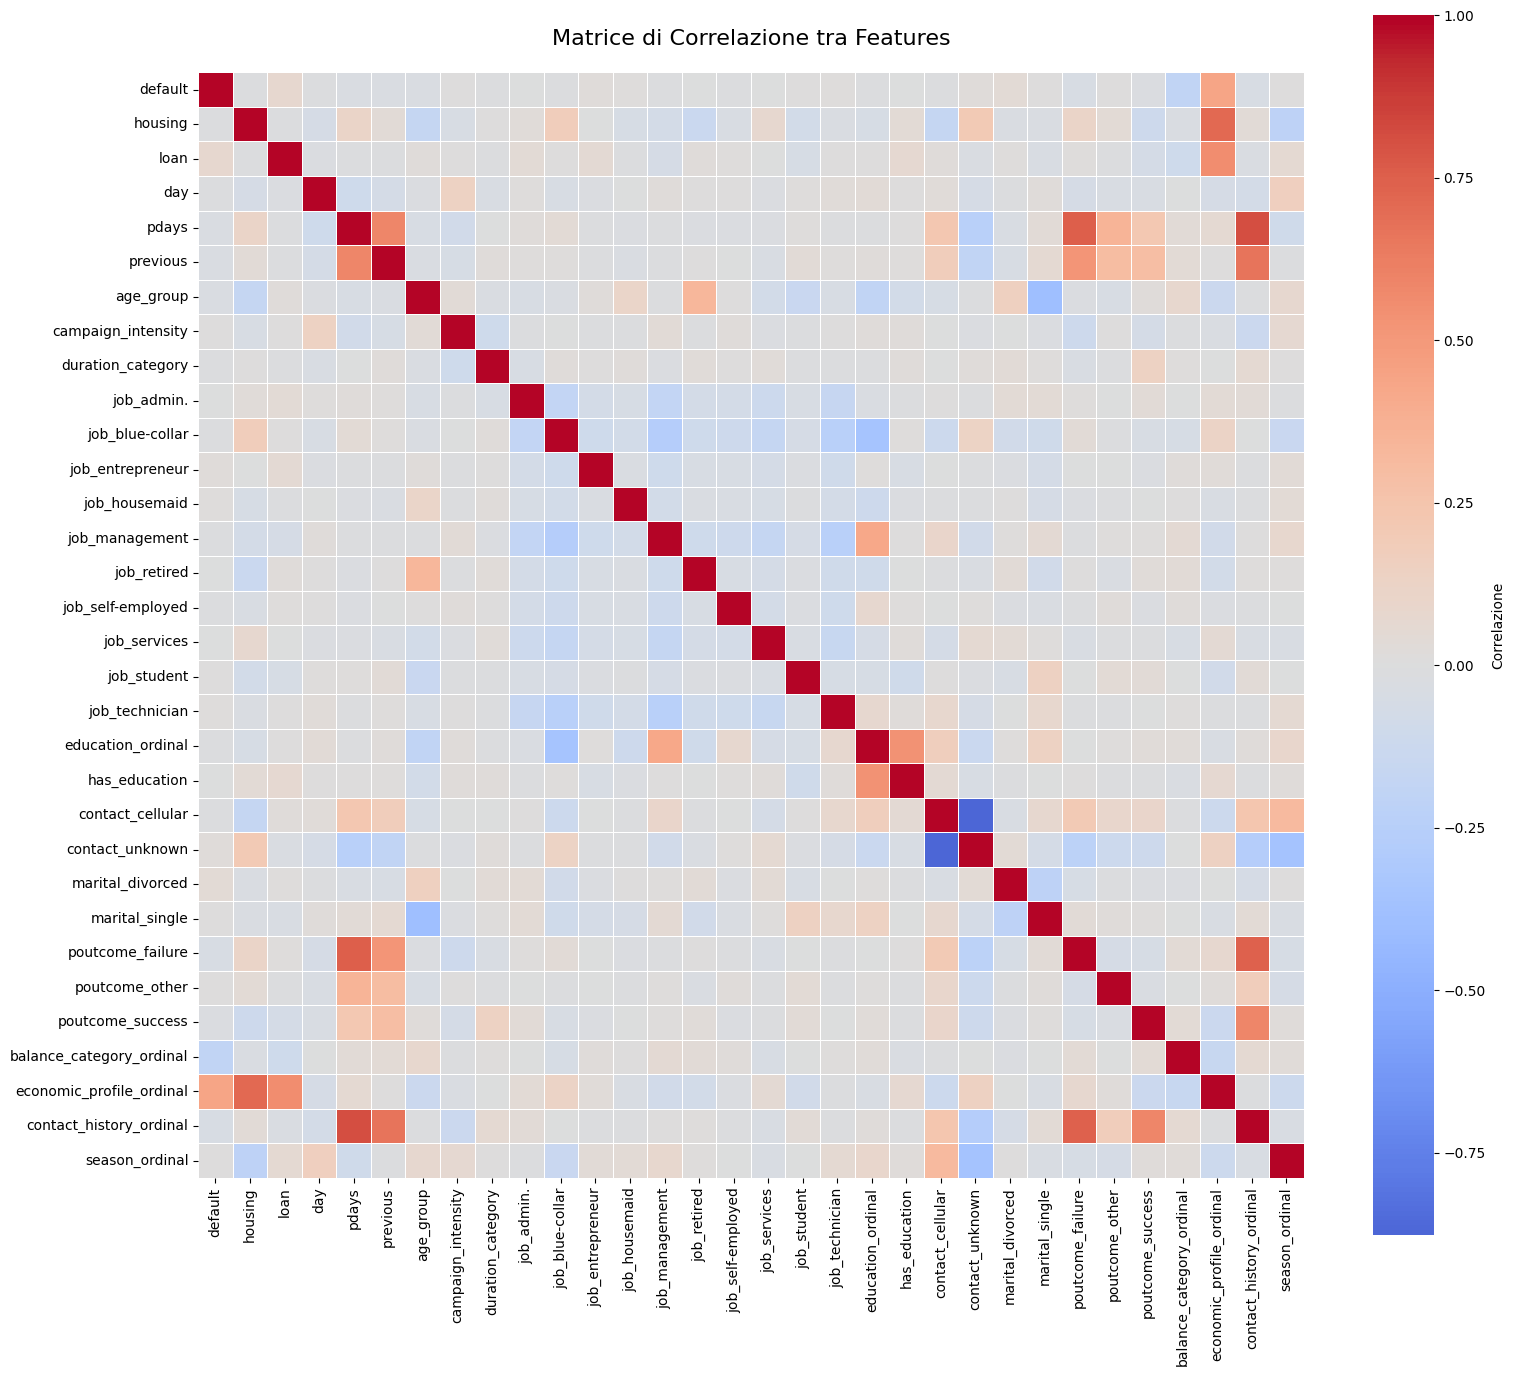


✓ Heatmap generata!


In [136]:
# ============================================================
# ANALISI CORRELAZIONI TRA FEATURES
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print(" ANALISI CORRELAZIONI")
print("="*60)

# Seleziona solo colonne numeriche (escludendo id, split, y)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
# Rimuovi colonne che non servono per l'analisi
cols_to_exclude = ['id', 'split']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

print(f"\nColonne numeriche analizzate: {len(numeric_cols)}")

# Calcola matrice di correlazione
corr_matrix = df[numeric_cols].corr()

print("\n1. TOP 10 CORRELAZIONI PIÙ ALTE (in valore assoluto):")
print("-"*60)

# Estrai correlazioni e ordina
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'feature_1': corr_matrix.columns[i],
            'feature_2': corr_matrix.columns[j],
            'correlation': corr_matrix.iloc[i, j]
        })

# Ordina per valore assoluto
import pandas as pd
corr_df = pd.DataFrame(corr_pairs)
corr_df['abs_corr'] = corr_df['correlation'].abs()
top_corr = corr_df.sort_values('abs_corr', ascending=False).head(10)

for idx, row in top_corr.iterrows():
    print(f"{row['feature_1']:30s} <-> {row['feature_2']:30s} : {row['correlation']:7.4f}")

# Visualizza heatmap
print("\n2. HEATMAP CORRELAZIONI:")
print("-"*60)
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, 
            cmap='coolwarm', 
            center=0, 
            annot=False,  # Troppi numeri, meglio senza
            fmt='.2f',
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Correlazione'})
plt.title('Matrice di Correlazione tra Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

print("\n✓ Heatmap generata!")

In [142]:
df.dtypes

id                           int64
split                       object
default                      int64
housing                      int64
loan                         int64
day                          int64
pdays                        int64
previous                     int64
y                            int64
age_group                     int8
campaign_intensity            int8
duration_category             int8
job_admin.                   int64
job_blue-collar              int64
job_entrepreneur             int64
job_housemaid                int64
job_management               int64
job_retired                  int64
job_self-employed            int64
job_services                 int64
job_student                  int64
job_technician               int64
education_ordinal            int64
has_education                int64
contact_cellular             int64
contact_unknown              int64
marital_divorced             int64
marital_single               int64
poutcome_failure    

In [141]:
# Converti y da 'yes'/'no' a 1/0
df['y'] = (df['y'] == 'yes').astype(int)

# Verifica
print("✓ Target 'y' convertito in numerico!")
print(f"Tipo: {df['y'].dtype}")
print(f"\nDistribuzione:")
print(df['y'].value_counts())
print(f"\nTasso conversione: {df['y'].mean()*100:.2f}%")

✓ Target 'y' convertito in numerico!
Tipo: int64

Distribuzione:
y
0    2889
1     174
Name: count, dtype: int64

Tasso conversione: 5.68%


In [143]:
# Salva il dataframe in CSV
df.to_csv('data/bank/bank_data_preprocessed.csv', index=False)

print("✓ Salvato in: data/bank/bank_data_preprocessed.csv")
print(f"✓ Shape: {df.shape}")

✓ Salvato in: data/bank/bank_data_preprocessed.csv
✓ Shape: (3063, 35)
